In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import lsstypes as types
from clustering_statistics import tools, plotting_tools

In [3]:
plot_dir = Path('_plots')
plot_dir.mkdir(exist_ok=True)
ext = 'png'

In [4]:
analysis = 'full_shape'
stat    = kind = 'mesh2_spectrum'
region  = 'GCcomb'
tracers = ['LRG', 'ELG_LOPnotqso', 'QSO']

version   = 'glam-uchuu-v1-altmtl'
cai_dir   = Path('/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe/')
stats_dir = cai_dir / analysis

ells4pk=(0,2,4)
ells4bk=((0,0,0),(2,0,2))

/global/u2/a/arosado/cai-dr2-clustering-products/clustering_statistics/plotting_tools.py:73: RuntimeWarning: invalid value encountered in divide
  ax.plot(pole.coords('k'), (pole.value() - means[reference].get(ell).value()).real / std, color=colors[version], linestyle=linestyles[version])


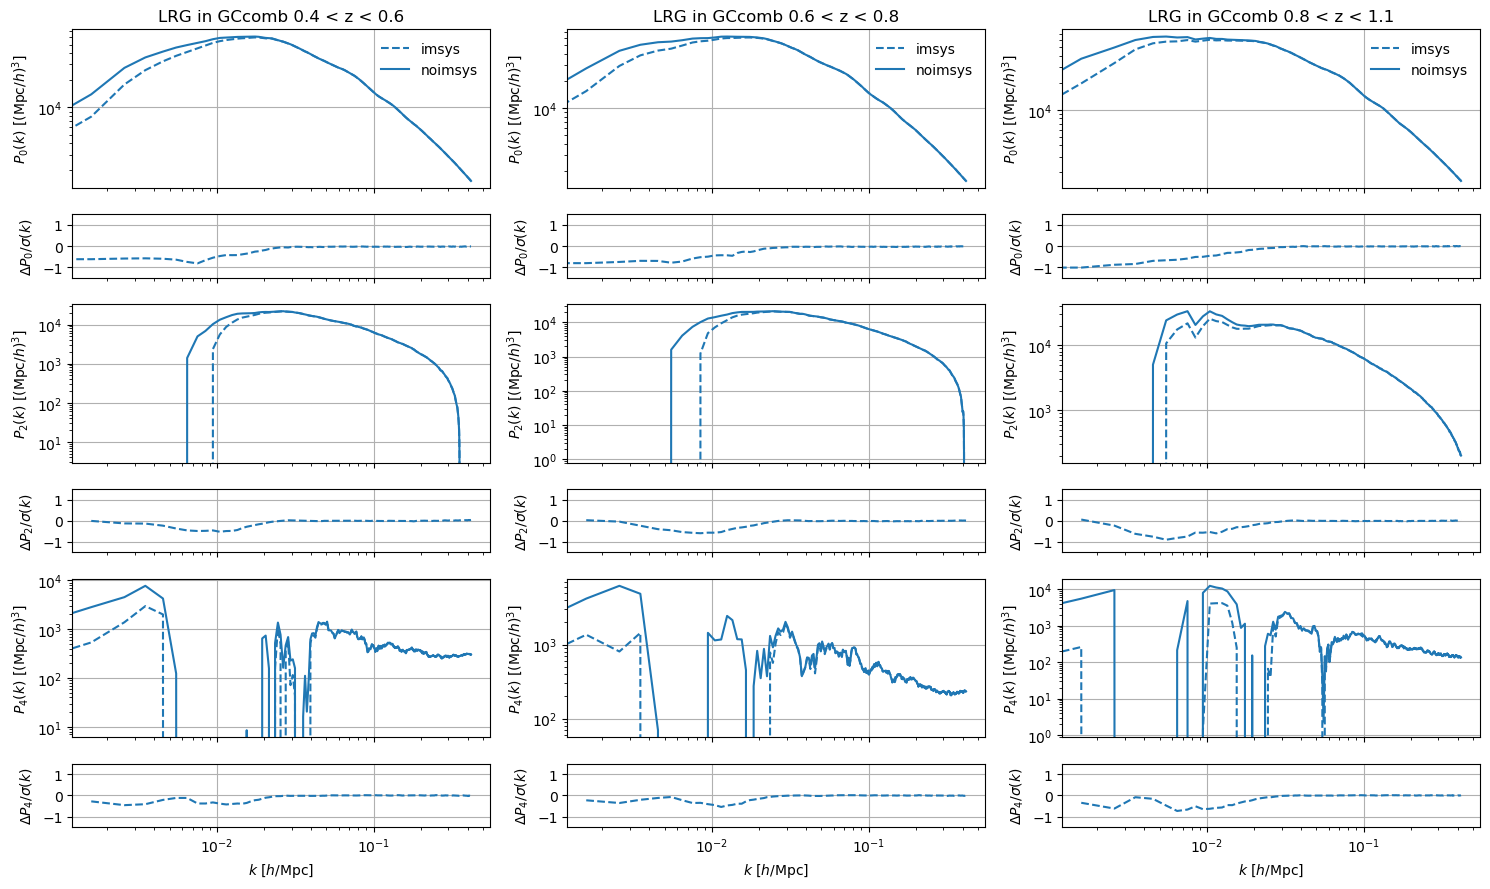

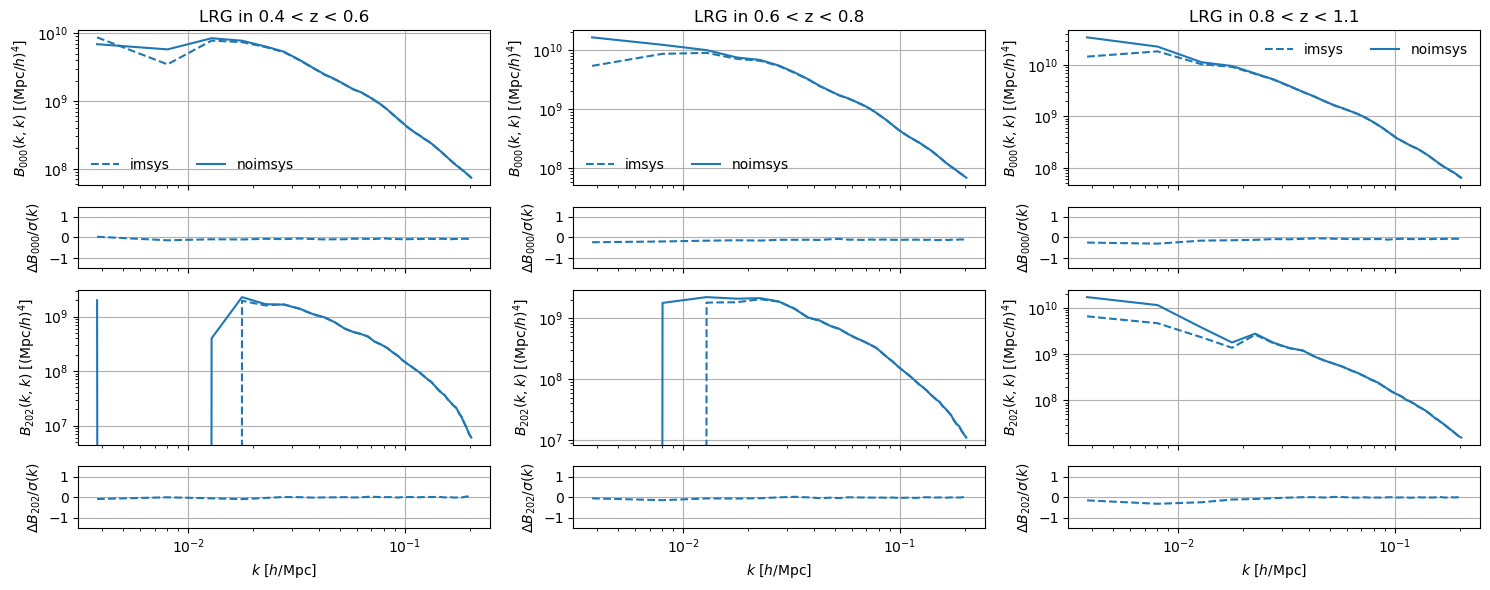

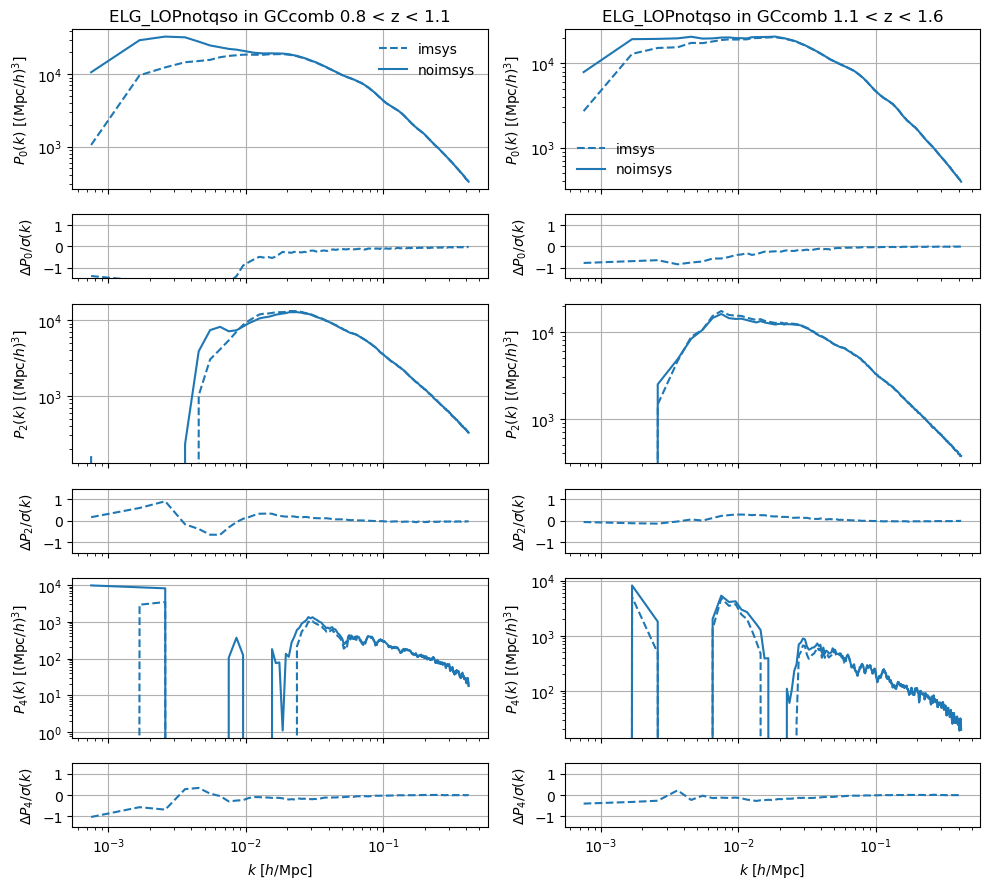

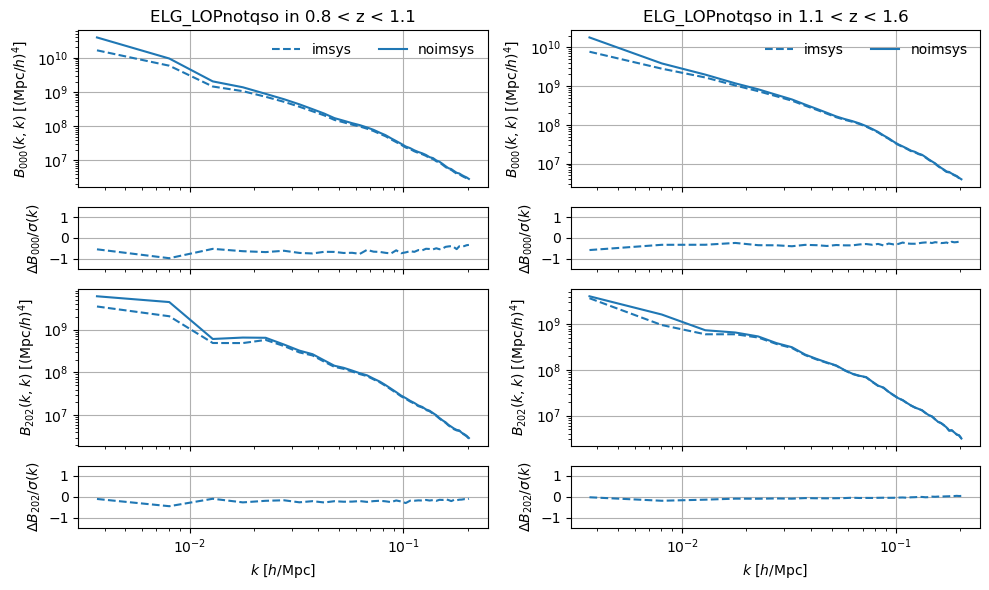

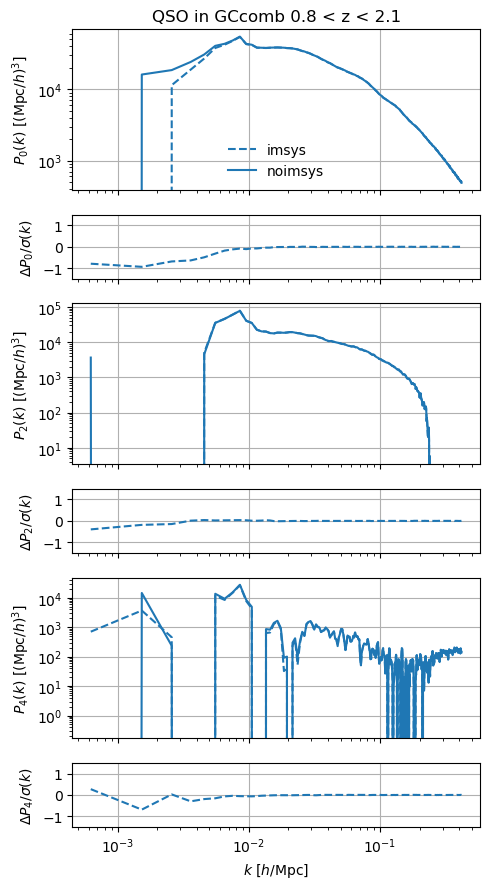

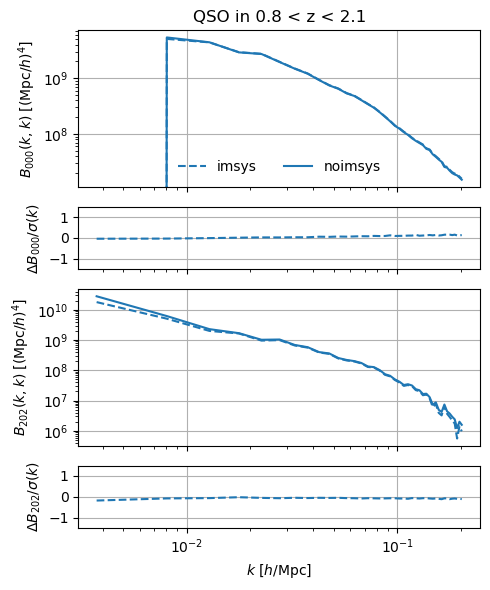

In [5]:
reference = 'noimsys'
cases = {'imsys':   {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default-FKP', 'cut': False, 'auw': False, 'extra':''},
         'noimsys': {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default-noimsys-FKP', 'cut': False, 'auw': False, 'extra':''}}

scaling='loglog'
colors = dict(zip(cases, ['C0', 'C0']))
linestyles = dict(zip(cases, ['--', '-']))
plot_kws = dict(colors=colors,linestyles=linestyles,scaling=scaling,stats_dir=stats_dir)

for tracer in tracers:
    zranges = tools.propose_fiducial('zranges',tracer,analysis=analysis)
    nrows  = len(ells4pk) * 2
    ncols  = len(zranges)
    figure = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * len(ells4pk)), sharex='col', gridspec_kw={'height_ratios': [2.5, 1] * len(ells4pk)})
    for iz, zrange in enumerate(zranges):    
        plot_kws = plot_kws|dict(reference=reference, figure=figure, ax_col=iz, ells=ells4pk)
        plotting_tools.plot_stats('mesh2_spectrum', cases, tracer, zrange, region, **plot_kws)
    plt.tight_layout()
    plt.show()

    nrows  = len(ells4bk) * 2
    ncols  = len(zranges)
    figure = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * len(ells4bk)), sharex='col', gridspec_kw={'height_ratios': [2.5, 1] * len(ells4bk)})
    for iz, zrange in enumerate(zranges):    
        plot_kws = plot_kws|dict(reference=reference, figure=figure, ax_col=iz, ells=ells4bk)
        plotting_tools.plot_stats('mesh3_spectrum_sugiyama-diagonal', cases, tracer, zrange, region, **plot_kws)
    plt.tight_layout()
    plt.show()

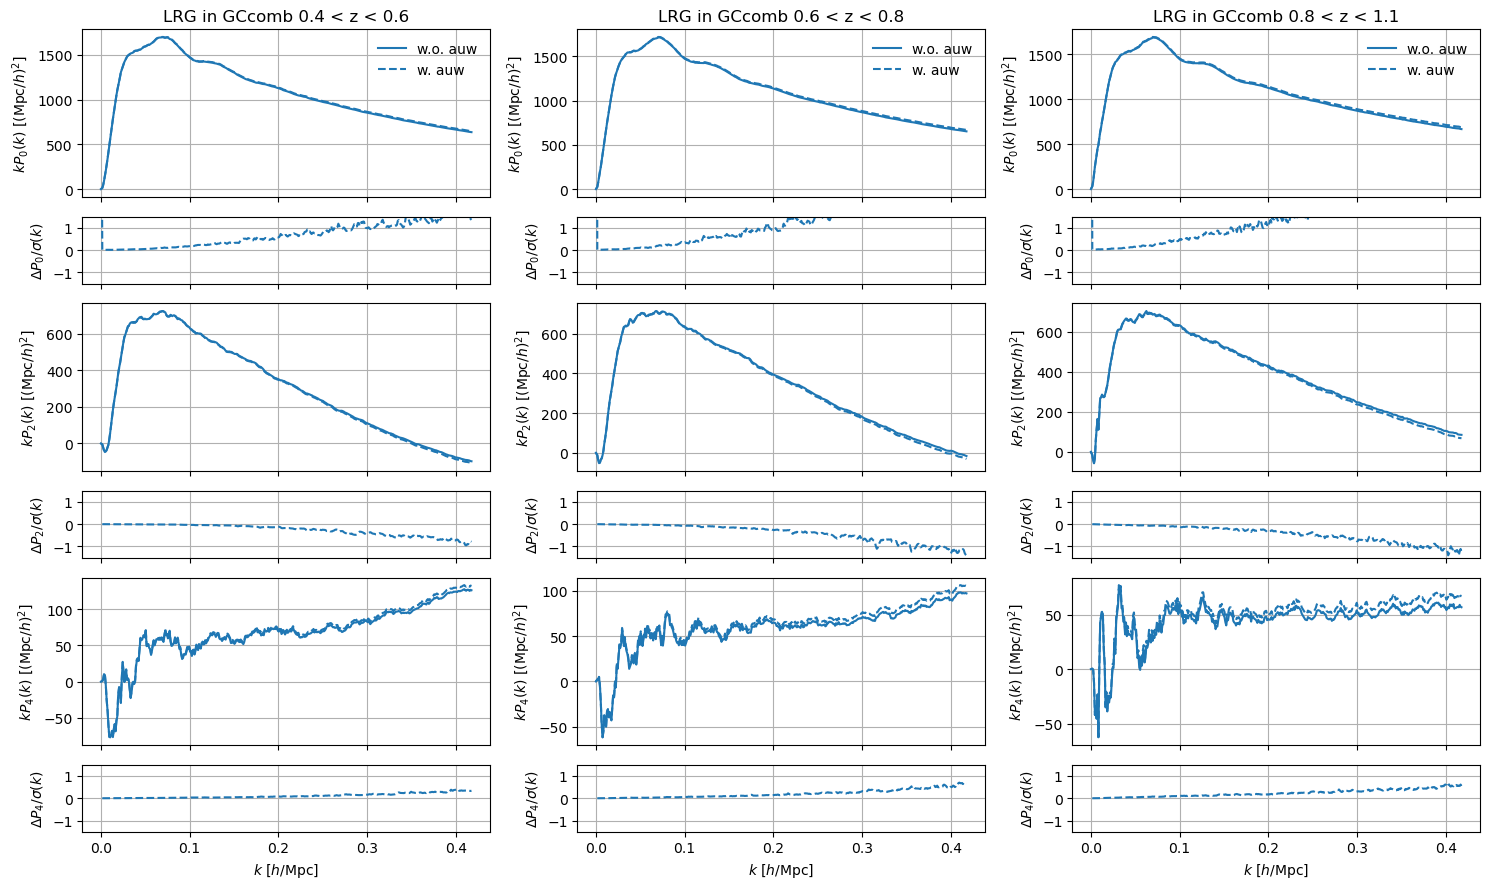

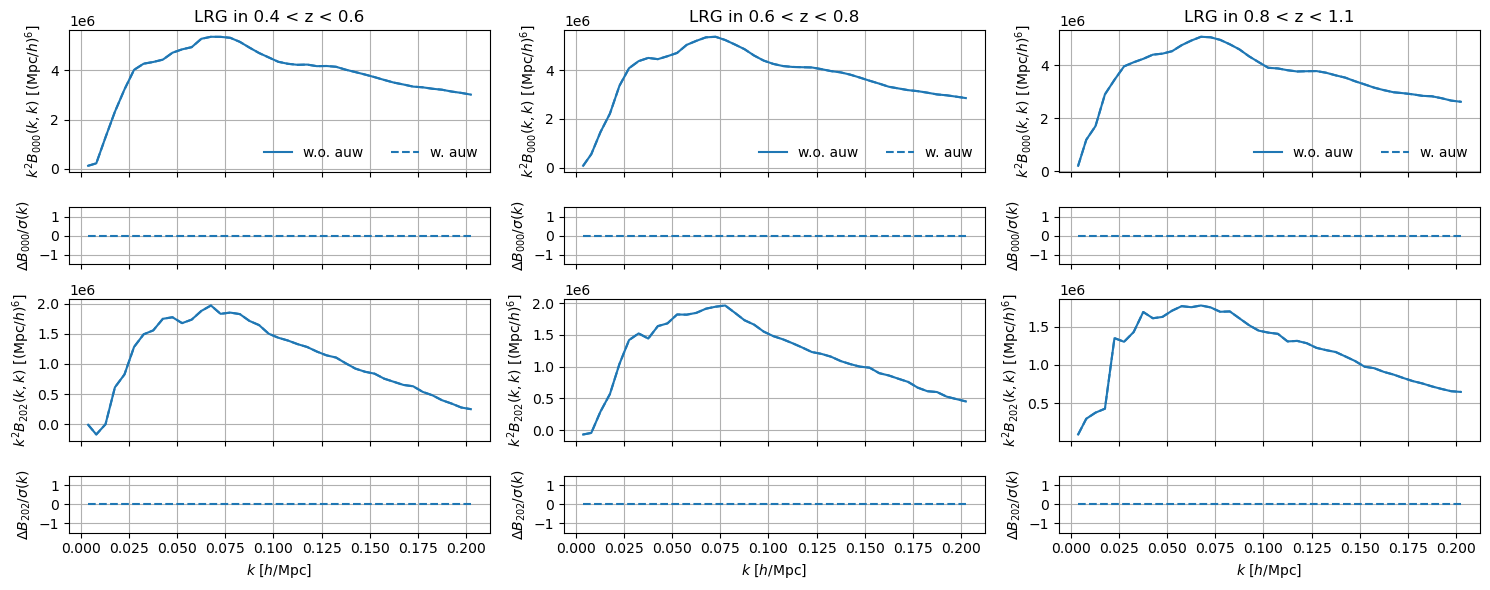

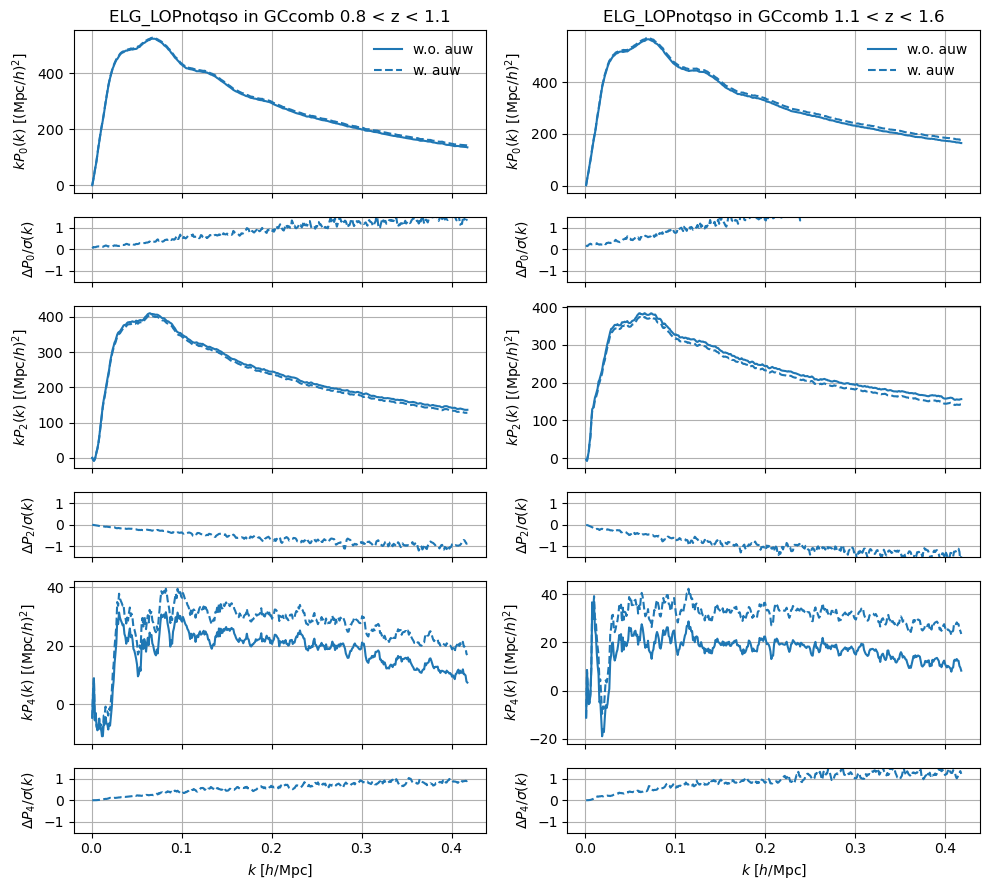

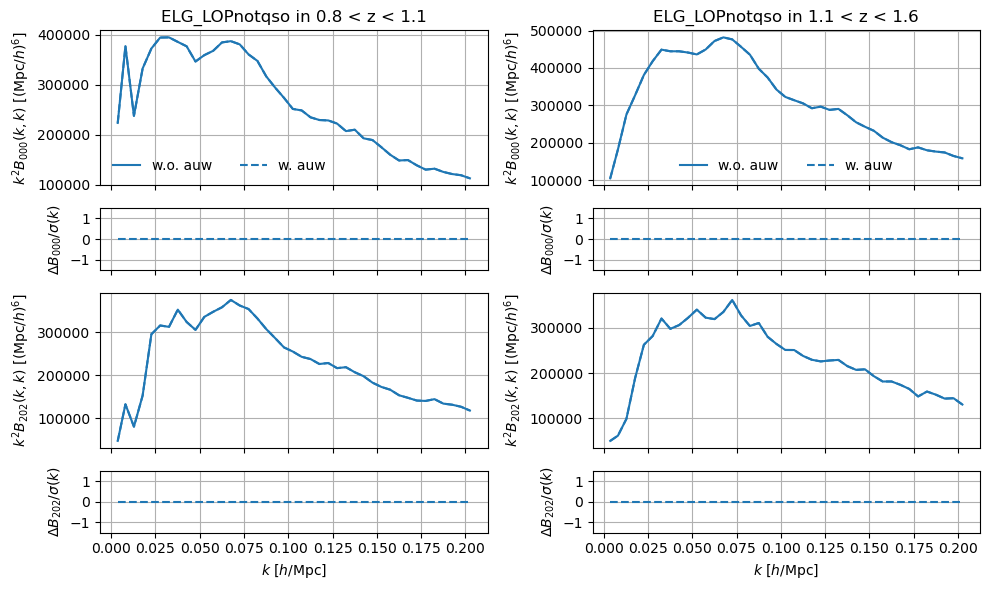

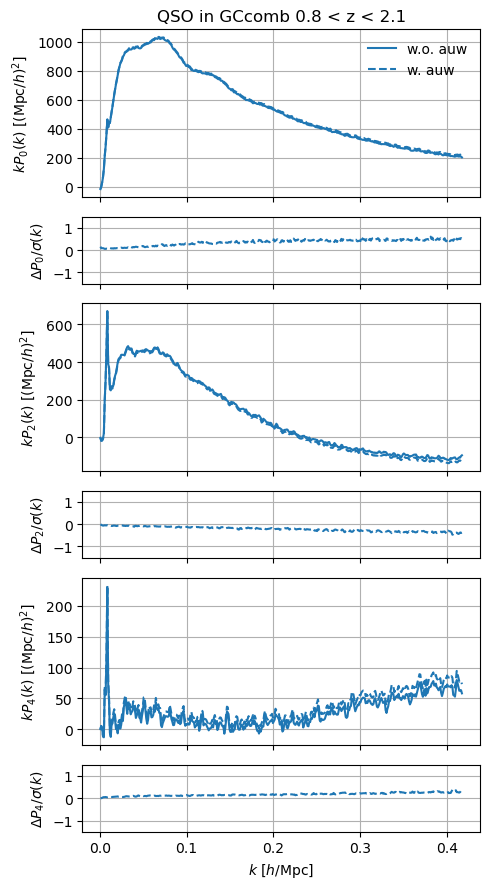

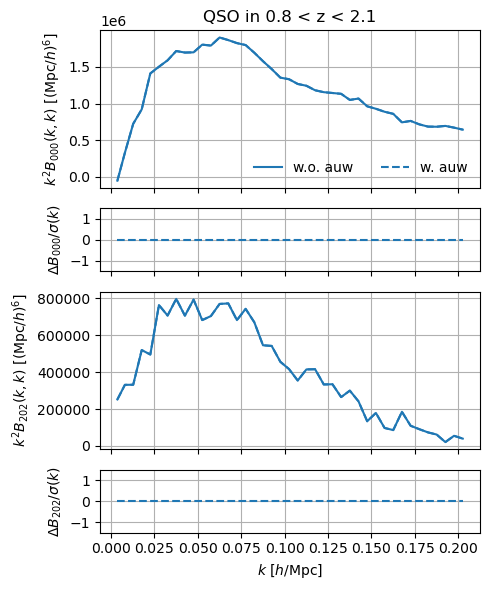

In [6]:
reference = 'w.o. auw'
cases = {'w.o. auw':   {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default-FKP', 'cut': False, 'auw': False, 'extra':''},
         'w. auw': {'version': 'glam-uchuu-v1-altmtl', 'weight': 'default-FKP', 'cut': False, 'auw': True, 'extra':''}}

scaling='kpk'
colors = dict(zip(cases, ['C0', 'C0']))
linestyles = dict(zip(cases, ['-', '--']))
plot_kws = dict(colors=colors,linestyles=linestyles,scaling=scaling,stats_dir=stats_dir)

for tracer in tracers:
    zranges = tools.propose_fiducial('zranges',tracer,analysis=analysis)
    nrows  = len(ells4pk) * 2
    ncols  = len(zranges)
    figure = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * len(ells4pk)), sharex='col', gridspec_kw={'height_ratios': [2.5, 1] * len(ells4pk)})
    for iz, zrange in enumerate(zranges):    
        plot_kws = plot_kws|dict(reference=reference, figure=figure, ax_col=iz, ells=ells4pk)
        plotting_tools.plot_stats('mesh2_spectrum', cases, tracer, zrange, region, **plot_kws)
    plt.tight_layout()
    plt.show()

    nrows  = len(ells4bk) * 2
    ncols  = len(zranges)
    figure = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * len(ells4bk)), sharex='col', gridspec_kw={'height_ratios': [2.5, 1] * len(ells4bk)})
    for iz, zrange in enumerate(zranges):    
        plot_kws = plot_kws|dict(reference=reference, figure=figure, ax_col=iz, ells=ells4bk)
        plotting_tools.plot_stats('mesh3_spectrum_sugiyama-diagonal', cases, tracer, zrange, region, **plot_kws)
    plt.tight_layout()
    plt.show()